<a href="https://colab.research.google.com/github/shyamsparrow/Jan-G4---NLP-Chatbot/blob/Models/Capstone_NLP_Chatbot_Jan_A_G4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - NLP Chatbot

### DOMAIN: 
Industrial safety. NLP based Chatbot.

### CONTEXT:
The database comes from one of the biggest industry in Brazil and in the world. It is an urgent need for industries/companies around the globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.

### DATA DESCRIPTION:
This The database is basically records of accidents from 12 different plants in 03 different countries which every line in the data is an occurrence of an accident.

### Columns description:
* Data: timestamp or time/date information
* Countries: which country the accident occurred (anonymised)
* Local: the city where the manufacturing plant is located (anonymised)
* Industry sector: which sector the plant belongs to
* Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
* Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have   been (due to other factors involved in the accident)
* Gender: if the person is male of female
* Employee or Third Party: if the injured person is an employee or a third party
* Critical Risk: some description of the risk involved in the accident
* Description: Detailed description of how the accident happened.

Link to download the dataset: https://drive.google.com/file/d/1_GmrRP1S2OIa02KlfOBNkYa8uxazGbfE/view?usp=sharing,
Original dataset link: https://www.kaggle.com/ihmstefanini/industrial-safety-and-health-analytics-database

### PROJECT OBJECTIVE:
Design a ML/DL based chatbot utility which can help the professionals to highlight the safety risk as per the incident description.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Replace the folder path with your drive folder path and clone the githb repo

In [7]:
%cd /content/drive/MyDrive/AIML/Capstone

/content/drive/MyDrive/AIML/Capstone


Run the below code for clone the repo in our Googele drive for first time

In [8]:
! git clone https://github.com/shyamsparrow/Jan-G4---NLP-Chatbot.git

fatal: destination path 'Jan-G4---NLP-Chatbot' already exists and is not an empty directory.


Change the Current folder into Github repo main folder, all the functions we are calling has to be in this repo.

In [9]:
%cd /content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot

/content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot


In [10]:
!git checkout Models

Already on 'Models'
Your branch is behind 'origin/Models' by 2 commits, and can be fast-forwarded.
  (use "git pull" to update your local branch)


In [89]:
!git pull

remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 25 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.
From https://github.com/shyamsparrow/Jan-G4---NLP-Chatbot
   562c431..49c4cce  Models          -> origin/Models
 * [new branch]      CNN_LSTM_Ganesh -> origin/CNN_LSTM_Ganesh
   6b96cb0..8db2fcb  Simple_Transformer_Model -> origin/Simple_Transformer_Model
Updating 562c431..49c4cce
Fast-forward
 Utilities/data_augmentation.csv | 412 ++++++++++++++++++++++++++++++++++++++++
 Utilities/result_df.csv         | Bin 0 -> 1612 bytes
 2 files changed, 412 insertions(+)
 create mode 100644 Utilities/data_augmentation.csv
 create mode 100644 Utilities/result_df.csv


Run this code to update the changes in repo to our drive

In [12]:
import warnings
warnings.filterwarnings('ignore')

import config
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [ ]:
url = "Data Set - industrial_safety_and_health_database_with_accidents_description.csv"
industry_df = pd.read_csv(url, index_col = 0)
industry_df.head

<bound method NDFrame.head of                     Data  ...                                        Description
0    2016-01-01 00:00:00  ...  While removing the drill rod of the Jumbo 08 f...
1    2016-01-02 00:00:00  ...  During the activation of a sodium sulphide pum...
2    2016-01-06 00:00:00  ...  In the sub-station MILPO located at level +170...
3    2016-01-08 00:00:00  ...  Being 9:45 am. approximately in the Nv. 1880 C...
4    2016-01-10 00:00:00  ...  Approximately at 11:45 a.m. in circumstances t...
..                   ...  ...                                                ...
434  2017-07-04 00:00:00  ...  Being approximately 5:00 a.m. approximately, w...
435  2017-07-04 00:00:00  ...  The collaborator moved from the infrastructure...
436  2017-07-05 00:00:00  ...  During the environmental monitoring activity i...
437  2017-07-06 00:00:00  ...  The Employee performed the activity of strippi...
438  2017-07-09 00:00:00  ...  At 10:00 a.m., when the assistant cleaned the ..

In [ ]:
industry_df.shape

(425, 10)

### Re-naming the column name:
We have 10 columns( features) and 425 rows of data. Let us Rename the column correctly, which is misspelled.

In [ ]:
industry_df.rename(columns={'Data':'Date', 'Countries':'Country', 'Genre':'Gender', 'Employee or Third Party':'Employee_type',
'Industry Sector':'Industry_Sector','Accident Level':'Accident_Level','Potential Accident Level':'Potential_Accident_Level',
'Critical Risk':'Critical_Risk'}, inplace=True)
industry_df.head(3)

### Checking Missing Values:

In [ ]:
datatype = pd.DataFrame(industry_df.dtypes)
datatype['MissingVal'] = industry_df.isnull().sum()
datatype['NUnique']=industry_df.nunique()
datatype

,0,MissingVal,NUnique
Date,object,0,287
Country,object,0,3
Local,object,0,12
Industry_Sector,object,0,3
Accident_Level,object,0,5
Potential_Accident_Level,object,0,6
Gender,object,0,2
Employee_type,object,0,3
Critical_Risk,object,0,33
Description,object,0,411


By Checking the missing value, we have 0 missing values in all 10 columns.

### Removing Duplicates:

In [ ]:
industry_df.duplicated().sum()

7

We have 7 duplicate values, let us check those values and remove it

In [ ]:
duplicates = industry_df.duplicated()
industry_df[duplicates]

,Date,Country,Local,Industry_Sector,Accident_Level,Potential_Accident_Level,Gender,Employee_type,Critical_Risk,Description
89,2016-04-01 00:00:00,Country_01,Local_01,Mining,I,V,Male,Third Party (Remote),Others,In circumstances that two workers of the Abrat...
276,2016-12-01 00:00:00,Country_01,Local_03,Mining,I,IV,Male,Employee,Others,During the activity of chuteo of ore in hopper...
317,2017-01-21 00:00:00,Country_02,Local_02,Mining,I,I,Male,Third Party (Remote),Others,Employees engaged in the removal of material f...
359,2017-03-02 00:00:00,Country_03,Local_10,Others,I,I,Male,Third Party,Venomous Animals,On 02/03/17 during the soil sampling in the re...
360,2017-03-02 00:00:00,Country_03,Local_10,Others,I,I,Male,Third Party,Venomous Animals,On 02/03/17 during the soil sampling in the re...
369,2017-03-15 00:00:00,Country_03,Local_10,Others,I,I,Male,Third Party,Venomous Animals,Team of the VMS Project performed soil collect...
411,2017-05-23 00:00:00,Country_01,Local_04,Mining,I,IV,Male,Third Party,Projection of fragments,In moments when the 02 collaborators carried o...


In [ ]:
industry_df.drop_duplicates(inplace=True)
industry_df.shape

(418, 10)

In [ ]:
industry_df["Description"].nunique()

411

One can observe in the above dataframe that there are only 411 unique values in the Description column but we have 418 number of records in total, we can assume that there are still 7 number of duplicate values on description column. We will check for those duplicates on column level and drop if required for further analysis.

In [ ]:
print('There are still {} duplicates in the dataset as below'.format(industry_df.duplicated(subset=['Description'],keep=False).sum()))
industry_df[industry_df.duplicated(subset=['Description'],keep=False)].sort_values(by='Description')


There are still 14 duplicates in the dataset as below


,Date,Country,Local,Industry_Sector,Accident_Level,Potential_Accident_Level,Gender,Employee_type,Critical_Risk,Description
180,2016-07-07 00:00:00,Country_01,Local_03,Mining,IV,V,Male,Third Party,Others,At moments when the MAPERU truck of plate F1T ...
181,2016-07-07 00:00:00,Country_01,Local_03,Mining,I,IV,Male,Third Party,Others,At moments when the MAPERU truck of plate F1T ...
275,2016-12-01 00:00:00,Country_01,Local_03,Mining,I,IV,Male,Employee,Others,During the activity of chuteo of ore in hopper...
277,2016-12-01 00:00:00,Country_01,Local_03,Mining,I,IV,Male,Third Party,Others,During the activity of chuteo of ore in hopper...
426,2017-06-20 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Employee,Others,"In circumstance, the AHK-903 license plate (Em..."
427,2017-06-20 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Others,"In circumstance, the AHK-903 license plate (Em..."
142,2016-05-26 00:00:00,Country_03,Local_10,Others,I,I,Male,Third Party,Bees,"In the geological reconnaissance activity, in ..."
143,2016-05-26 00:00:00,Country_03,Local_10,Others,I,I,Male,Employee,Others,"In the geological reconnaissance activity, in ..."
155,2016-06-08 00:00:00,Country_03,Local_10,Others,I,I,Male,Third Party,Bees,Project of Vazante that carried out sediment c...
156,2016-06-08 00:00:00,Country_03,Local_10,Others,I,I,Male,Third Party,Others,Project of Vazante that carried out sediment c...


We can cleary observe that the above dataframe contains 7 duplicates in which only one or two column values are dissimilar among the datapoints where in the Description is matching, which is logically unsound.
It can also be noticed that the incidents which are having duplicate values happened on the time stamp(Date Column).
Hence we will be dropping these hidden duplicates which doesn't seem right logically.

In [ ]:
# Dropping the duplicates we detected above.
industry_df.drop_duplicates(subset=['Description'], keep='first', inplace=True)
print('After removing duplicates the shape of the dataset is:', industry_df.shape)

After removing duplicates the shape of the dataset is: (411, 10)


### Checking Outliers:

In [ ]:
for x in industry_df.columns:
    if x != 'Description' and x != 'Date':
        print('--'*30); print(f'Unique values of "{x}" column'); print('--'*30)
        print(industry_df[x].unique())
        print("\n")

------------------------------------------------------------
Unique values of "Country" column
------------------------------------------------------------
['Country_01' 'Country_02' 'Country_03']


------------------------------------------------------------
Unique values of "Local" column
------------------------------------------------------------
['Local_01' 'Local_02' 'Local_03' 'Local_04' 'Local_05' 'Local_06'
 'Local_07' 'Local_08' 'Local_10' 'Local_09' 'Local_11' 'Local_12']


------------------------------------------------------------
Unique values of "Industry_Sector" column
------------------------------------------------------------
['Mining' 'Metals' 'Others']


------------------------------------------------------------
Unique values of "Accident_Level" column
------------------------------------------------------------
['I' 'IV' 'III' 'II' 'V']


------------------------------------------------------------
Unique values of "Potential_Accident_Level" column
------------

By checking all the unique values of all columns in the dataset, we can say there is no Outlier in this column. 

We have only 3 countries, 12 Locals, 3 Industry sectors, 5 accident levels, 6 potential accident levels, 3 Employee types and 33 Critical Risks including Not applicable.

Five type of accident levels (1 to 5) are present.
Six type of Potential Accident Levels (1 to 6) and we see that there is only one value registered under 'Accident level 6'

In [ ]:
industry_df['Potential_Accident_Level'] = industry_df['Potential_Accident_Level'].replace('VI', 'V')

In [ ]:
industry_df = industry_df.reset_index(drop=True)

Removed all Duplicate values

In [ ]:
industry_df.describe()

,Date,Country,Local,Industry_Sector,Accident_Level,Potential_Accident_Level,Gender,Employee_type,Critical_Risk,Description
count,411,411,411,411,411,411,411,411,411,411
unique,287,3,12,3,5,5,2,3,33,411
top,2017-02-08 00:00:00,Country_01,Local_03,Mining,I,IV,Male,Third Party,Others,"In the DDH chamber of the company Explomin, lo..."
freq,6,245,87,232,303,138,390,180,223,1


We have 411 unique descriptions in the dataset.

In [ ]:
print(industry_df.Date.min())
print(industry_df.Date.max())

2016-01-01 00:00:00
2017-07-09 00:00:00


The Accidents are captured in the year 2016- January to 2017 July. ~ 19 months of data.

Let us split the date value into year, month, day, name of the day and week of the year.

In [ ]:
industry_df['Date'] = pd.to_datetime(industry_df['Date'])
industry_df['Year'] = industry_df['Date'].apply(lambda x : x.year)
industry_df['Month'] = industry_df['Date'].apply(lambda x : x.month)
industry_df['Day'] = industry_df['Date'].apply(lambda x : x.day)
industry_df['Weekday'] = industry_df['Date'].apply(lambda x : x.day_name())
industry_df['WeekofYear'] = industry_df['Date'].apply(lambda x : x.weekofyear)
industry_df.head(3)

,Date,Country,Local,Industry_Sector,Accident_Level,Potential_Accident_Level,Gender,Employee_type,Critical_Risk,Description,Year,Month,Day,Weekday,WeekofYear
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1,Friday,53
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,2,Saturday,53
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,6,Wednesday,1


Accordin to this discussion, countries where the dataset was collected is anonymized but they are all located in South America. So in this analysis, let's assume the dataset was collected in Brazil.
It is said in this web page that Brazil has four climatological seasons as below.

*   Spring : September to November
*   Summer : December to February
*   Autumn : March to May
*   Winter : June to August

We can create seasonal variable based on month variable.


In [ ]:
def month2seasons(x):
    if x in [9, 10, 11]:
        season = 'Spring'
    elif x in [12, 1, 2]:
        season = 'Summer'
    elif x in [3, 4, 5]:
        season = 'Autumn'
    elif x in [6, 7, 8]:
        season = 'Winter'
    return season

In [ ]:
industry_df['Season'] = industry_df['Month'].apply(month2seasons)
industry_df.head(3)

,Date,Country,Local,Industry_Sector,Accident_Level,Potential_Accident_Level,Gender,Employee_type,Critical_Risk,Description,Year,Month,Day,Weekday,WeekofYear,Season
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1,Friday,53,Summer
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,2,Saturday,53,Summer
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,6,Wednesday,1,Summer


Let us check the time date and the spread of data across time.

In [ ]:
year_data = pd.DataFrame(industry_df.dtypes)
year_data['NUnique']=industry_df.nunique()
year_data.iloc[10:16]

,0,NUnique
Year,int64,2
Month,int64,12
Day,int64,31
Weekday,object,7
WeekofYear,int64,53
Season,object,4


In [ ]:
datelist = ['Year','Month','Day','Weekday','Season']
for x in datelist:
    print('--'*30); print(f'Unique values of "{x}" column'); print('--'*30)
    print(industry_df[x].unique())
    print("\n")

------------------------------------------------------------
Unique values of "Year" column
------------------------------------------------------------
[2016 2017]


------------------------------------------------------------
Unique values of "Month" column
------------------------------------------------------------
[ 1  2  3  4  5  6  7  8  9 10 11 12]


------------------------------------------------------------
Unique values of "Day" column
------------------------------------------------------------
[ 1  2  6  8 10 12 16 17 19 26 28 30  4  7 21 25  9 15 14 13 20 18 22 24
 29 27  3  5 11 31 23]


------------------------------------------------------------
Unique values of "Weekday" column
------------------------------------------------------------
['Friday' 'Saturday' 'Wednesday' 'Sunday' 'Tuesday' 'Thursday' 'Monday']


------------------------------------------------------------
Unique values of "Season" column
------------------------------------------------------------
['S

* We have accidents happened between 2016 to 2017 as per year column.
* The accidents is spread across all months, days and weekday.

Install pyspellchecker library for spell check.

In [ ]:
!pip install contractions
!pip install pyspellchecker
verbose= False

     |████████████████████████████████| 321 kB 39.5 MB/s 
     |████████████████████████████████| 284 kB 66.1 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85436 sha256=74c1ab7ff2a8aa89fed177a4294d0af9b8f222576c8ed6691b0ed869708a841b
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
     |████████████████████████████████| 2.7 MB 35.9 MB/s 


We created a NLP_text_preprocess.py file and added all our preprocess steps there, from the config file we are passing the flags to our class PreProcessing in our python file.

We are doing the following steps for our preprocessing.

* Convert into Lower case
* Removing the URl
* Removing the Special characters
* Removing Punctuation
* Removing Whitespaces
* Check the spelling mistakes
* Removing the stopwords
* Convert the words into lemma form

In [ ]:
from NLP_text_preprocess import PreProcessing

In [ ]:
pp = PreProcessing(to_lower = config.to_lower,remove_url=config.remove_url,
                   remove_time = config.remove_time,expand_contraction =config.expand_contraction,
                   remove_special_character=config.remove_special_character,
                   remove_punctuation=config.remove_punctuation,
                   remove_whitespace=config.remove_whitespace,
                   keep_alpha_numeric = False,
                   check_spelling=config.check_spelling,
                   remove_stopword=False,
                   lemmatize_word=config.lemmatize_word)

pp.preprocess(industry_df.Description[1])

'during the activation of a sodium sulphide pump the piping wa uncoupled and the sulfide solution wa designed in the area to reach the maid immediately she made use of the emergency shower and wa directed to the ambulatory doctor and later to the hospital note of sulphide solution 48 gram liter'

We Preprocess the entire description column and save it in Description_preprocessed.

In [ ]:
industry_df['Description_preprocessed'] = industry_df.Description.apply(lambda x: pp.preprocess(x))

In [ ]:
industry_df.head()

,Date,Country,Local,Industry_Sector,Accident_Level,Potential_Accident_Level,Gender,Employee_type,Critical_Risk,Description,Year,Month,Day,Weekday,WeekofYear,Season,Description_preprocessed
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1,Friday,53,Summer,while removing the drill rod of the jumbo 08 f...
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,2,Saturday,53,Summer,during the activation of a sodium sulphide pum...
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,6,Wednesday,1,Summer,in the substation milo located at level 170 wh...
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,2016,1,8,Friday,1,Summer,being approximately in the no 1880 cx695 ob th...
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,2016,1,10,Sunday,1,Summer,approximately at in circumstance that the mech...


## LSTM:

In [102]:
industry_df.to_csv('industry_df_with_stopwords.csv', index=False)

In [11]:
industry_df = pd.read_csv("industry_df_with_stopwords.csv")

In [ ]:
pd.crosstab(industry_df['Accident_Level'],industry_df['Potential_Accident_Level'])

Potential_Accident_Level,I,II,III,IV,V
Accident_Level,,,,,
I,43,88,89,75,8
II,0,7,14,16,2
III,0,0,3,26,2
IV,0,0,0,21,9
V,0,0,0,0,8


In [ ]:
industry_df['Potential_Accident_Level'].value_counts()

IV     138
III    106
II      95
I       43
V       29
Name: Potential_Accident_Level, dtype: int64

In [ ]:
industry_df['Accident_Level'].value_counts()

I      303
II      39
III     31
IV      30
V        8
Name: Accident_Level, dtype: int64

In [153]:
from nltk.tokenize import word_tokenize
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import pickle

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, LSTM,  Embedding, Dropout, Bidirectional, GlobalMaxPool1D

from keras.utils import np_utils
from keras.layers.merge import Concatenate
#from keras.utils import plot_model

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Keras pre-processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [154]:
# Select input and output features

X_text = ind_aug['Description']
y_text = ind_aug['Potential_Accident_Level']

In [155]:
# Encode labels in column 'Potential Accident Level'and Convert into one-hot encoded vectors:
le = LabelEncoder()
le.fit(y_text)
y_text = le.transform(y_text)
y_text = np_utils.to_categorical(y_text)

In [156]:
# Divide our data into testing and training sets:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text, y_text, test_size = 0.20, random_state = 1)

print('X_text_train shape : ({0})'.format(X_text_train.shape))
print('y_text_train shape : ({0},)'.format(y_text_train.shape))
print('X_text_test shape : ({0})'.format(X_text_test.shape))
print('y_text_test shape : ({0},)'.format(y_text_test.shape))

X_text_train shape : ((657,))
y_text_train shape : ((657, 5),)
X_text_test shape : ((165,))
y_text_test shape : ((165, 5),)


In [157]:
X_text_train[1]

'During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter.'

In [158]:
# The first step in word embeddings is to convert the words into thier corresponding numeric indexes.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_text_train)

X_text_train = tokenizer.texts_to_sequences(X_text_train)
X_text_test = tokenizer.texts_to_sequences(X_text_test)

In [161]:
industry_df['nb_words'] = ind_aug['Description'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(industry_df['nb_words'].min()))
print('Maximum number of words: {}'.format(industry_df['nb_words'].max()))

Minimum number of words: 16
Maximum number of words: 183


In [162]:
vocab_size = len(tokenizer.word_index) + 1
print("vocab_size:", vocab_size)

maxlen = 185

X_text_train = pad_sequences(X_text_train, padding='post', maxlen=maxlen)
X_text_test = pad_sequences(X_text_test, padding='post', maxlen=maxlen)

vocab_size: 3941


In [112]:
X_text_train.shape

(328, 185)

In [ ]:
print('Indexing word vectors.')

embeddings_dictionary = {}
f = open('glove.6B.200d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dictionary[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_dictionary))

In [ ]:
pickle.dump(embeddings_dictionary, open('/content/drive/MyDrive/AIML/Capstone/embeddings.pickle', 'wb'))

In [73]:
infile = open('/content/drive/MyDrive/AIML/Capstone/embeddings.pickle','rb')
embeddings_dictionary = pickle.load(infile)

In [163]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [166]:
vocab = build_vocab(ind_aug['Description'])

In [167]:
len(vocab)

6208

In [168]:
import operator 

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [169]:
oov_glove = check_coverage(vocab, embeddings_dictionary)

Found embeddings for 58.99% of vocab
Found embeddings for  87.85% of all text


In [170]:
embedding_size = 200

embedding_matrix = np.zeros((vocab_size, embedding_size))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
embedding_matrix.shape

(3941, 200)

In [ ]:
base_model = Sequential()
base_model.add(Embedding(vocab_size, output_dim=embedding_size, weights=[embedding_matrix], input_length=185, trainable=False))
#LSTM 
base_model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
base_model.add(Dense(5, activation='softmax'))
base_model.compile(optimizer=optimizers.Adam(lr = 0.001), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
base_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 185, 200)          568200    
                                                                 
 bidirectional_11 (Bidirecti  (None, 256)              336896    
 onal)                                                           
                                                                 
 dense_23 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 906,381
Trainable params: 906,381
Non-trainable params: 0
_________________________________________________________________


In [171]:
X_text_train.shape,y_text_train.shape,X_text_test.shape, y_text_test.shape

((657, 185), (657, 5), (165, 185), (165, 5))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.001)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=3, min_delta=1E-4)

# fit the keras model on the dataset
base_model_history = base_model.fit(X_text_train, y_text_train, epochs=10, batch_size=8, verbose=1, validation_data=(X_text_test, y_text_test), callbacks=[rlrp])

Epoch 1/10
41/41 [==============================] - 43s 951ms/step - loss: 0.5088 - acc: 0.2744 - val_loss: 0.4586 - val_acc: 0.3976 - lr: 0.0010
Epoch 2/10
41/41 [==============================] - 40s 981ms/step - loss: 0.4719 - acc: 0.3323 - val_loss: 0.4563 - val_acc: 0.3494 - lr: 0.0010
Epoch 3/10
41/41 [==============================] - 38s 928ms/step - loss: 0.4622 - acc: 0.3476 - val_loss: 0.4493 - val_acc: 0.3494 - lr: 0.0010
Epoch 4/10
41/41 [==============================] - 38s 934ms/step - loss: 0.4538 - acc: 0.3811 - val_loss: 0.4494 - val_acc: 0.3253 - lr: 0.0010
Epoch 5/10
41/41 [==============================] - 38s 931ms/step - loss: 0.4376 - acc: 0.4329 - val_loss: 0.4679 - val_acc: 0.3373 - lr: 0.0010
Epoch 6/10
41/41 [==============================] - 38s 926ms/step - loss: 0.4141 - acc: 0.4787 - val_loss: 0.4393 - val_acc: 0.3976 - lr: 0.0010
Epoch 7/10
41/41 [==============================] - 38s 934ms/step - loss: 0.3715 - acc: 0.5732 - val_loss: 0.4796 - val_acc

In [ ]:
_, train_accuracy = base_model.evaluate(X_text_train, y_text_train, batch_size=8, verbose=0)
_, test_accuracy = base_model.evaluate(X_text_test, y_text_test, batch_size=8, verbose=0)

print('Train accuracy: %.2f' % (train_accuracy*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

Train accuracy: 83.84
Test accuracy: 38.55


In [172]:

# Build a LSTM Neural Network
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], trainable=False)(deep_inputs)

LSTM_Layer_1 = Bidirectional(LSTM(128, return_sequences = True))(embedding_layer)
max_pool_layer_1 = GlobalMaxPool1D()(LSTM_Layer_1)
drop_out_layer_1 = Dropout(0.5, input_shape = (256,))(max_pool_layer_1)
dense_layer_1 = Dense(128, activation = 'relu')(drop_out_layer_1)
drop_out_layer_2 = Dropout(0.5, input_shape = (128,))(dense_layer_1)
dense_layer_2 = Dense(64, activation = 'relu')(drop_out_layer_2)
drop_out_layer_3 = Dropout(0.5, input_shape = (64,))(dense_layer_2)

dense_layer_3 = Dense(32, activation = 'relu')(drop_out_layer_3)
drop_out_layer_4 = Dropout(0.5, input_shape = (32,))(dense_layer_3)

dense_layer_4 = Dense(10, activation = 'relu')(drop_out_layer_4)
drop_out_layer_5 = Dropout(0.5, input_shape = (10,))(dense_layer_4)

dense_layer_5 = Dense(5, activation='softmax')(drop_out_layer_5)

lstm_model = Model(inputs=deep_inputs, outputs=dense_layer_5)

opt = optimizers.Adam(lr=0.001)
#opt = optimizers.SGD(lr=0.0001, momentum=0.9)
lstm_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

In [173]:
print(lstm_model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 185)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 185, 200)          788200    
                                                                 
 bidirectional_2 (Bidirectio  (None, 185, 256)         336896    
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               3289

In [ ]:
!pip install plot_model

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(lstm_model, to_file='model.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [174]:
class Metrics(tf.keras.callbacks.Callback):

    def __init__(self, validation_data=()):
        super().__init__()
        self.validation_data = validation_data

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        xVal, yVal = self.validation_data
        val_predict_classes = (np.asarray(self.model.predict(xVal))).round() # Multilabel
        
        
        val_targ = yVal

        _val_f1 = f1_score(val_targ, val_predict_classes, average='micro')
        _val_recall = recall_score(val_targ, val_predict_classes, average='micro')
        _val_precision = precision_score(val_targ, val_predict_classes, average='micro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        #print("— train_f1: %f — train_precision: %f — train_recall %f" % (_val_f1, _val_precision, _val_recall))
        return

In [175]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=1E-2)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3, min_delta=1E-2)

metrics = Metrics(validation_data=(X_text_train, y_text_train))

# fit the keras model on the dataset
training_history = lstm_model.fit(X_text_train, y_text_train, epochs=20, batch_size=8, verbose=1, validation_data=(X_text_test, y_text_test), callbacks=[rlrp,metrics])

Epoch 1/20
83/83 [==============================] - 47s 436ms/step - loss: 1.6343 - acc: 0.2268 - val_loss: 1.5800 - val_acc: 0.3455 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - 32s 389ms/step - loss: 1.5948 - acc: 0.2938 - val_loss: 1.5649 - val_acc: 0.3455 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - 33s 395ms/step - loss: 1.5623 - acc: 0.2877 - val_loss: 1.5536 - val_acc: 0.3455 - lr: 0.0010
Epoch 4/20
83/83 [==============================] - 31s 378ms/step - loss: 1.5477 - acc: 0.3303 - val_loss: 1.5319 - val_acc: 0.3455 - lr: 0.0010
Epoch 5/20
83/83 [==============================] - 32s 383ms/step - loss: 1.5269 - acc: 0.3105 - val_loss: 1.5199 - val_acc: 0.3455 - lr: 0.0010
Epoch 6/20
83/83 [==============================] - 76s 920ms/step - loss: 1.5274 - acc: 0.3014 - val_loss: 1.5196 - val_acc: 0.3455 - lr: 0.0010
Epoch 7/20
83/83 [==============================] - 32s 381ms/step - loss: 1.5199 - acc: 0.3196 - val_loss: 1.5115 - val_acc

KeyboardInterrupt: ignored

In [ ]:
with open('/content/drive/MyDrive/AIML/Capstone/parameters.pickle', "wb") as f:
  pickle.dump((le, tokenizer), f)

In [85]:
lstm_model_json = lstm_model.to_json()
with open("LSTM_aug_model.json", "w") as json_file:
    json_file.write(lstm_model_json)
    
# serialize weights to HDF5
lstm_model.save_weights("LSTM_aug_model_weights.h5")
print("Saved model weights to disk")

# Save the model in h5 format 
lstm_model.save("LSTM_aug_model.h5")
print("Saved model to disk")

Saved model weights to disk
Saved model to disk


In [86]:
# evaluate the keras model
_, train_accuracy = lstm_model.evaluate(X_text_train, y_text_train, batch_size=8, verbose=0)
_, test_accuracy = lstm_model.evaluate(X_text_test, y_text_test, batch_size=8, verbose=0)

print('Train accuracy: %.2f' % (train_accuracy*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

Train accuracy: 33.33
Test accuracy: 34.55


In [90]:
  with open('/content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot/Utilities/result_df.csv', "rb") as f:
      result_df = pickle.load(f)

In [93]:
y_pred = lstm_model.predict(X_text_test, verbose=0) # Multiclass
y_pred_index = np.argmax(y_pred,axis=1)
y_original = np.argmax(y_text_test, axis =1)

In [95]:
_,tr_accuracy = lstm_model.evaluate(X_text_train,y_text_train) 
_,te_accuracy = lstm_model.evaluate(X_text_test,y_text_test) 

F1_sre= f1_score(y_original,y_pred_index, average='micro')
tr_accuracy,te_accuracy,F1_sre

6/6 [==============================] - 1s 216ms/step - loss: 1.4804 - acc: 0.3455


(0.3333333432674408, 0.34545454382896423, 0.34545454545454546)

In [96]:
result_df.loc[len(result_df.index)] = ['LSTM_Aug_Model', tr_accuracy, te_accuracy,F1_sre] 
result_df

,Model,Train_accuracy,Test_accuracy,F1_score
0,LogReg,0.890244,0.890244,0.373494
1,Naive Bayes,1.000000,1.000000,0.421687
2,KNN,0.591463,0.591463,0.361446
3,SVM,0.990854,0.990854,0.361446
4,Decision Tree,0.512195,0.512195,0.313253
5,RandomForest,0.612805,0.612805,0.373494
6,Bagging,1.000000,1.000000,0.373494
7,AdaBoost,0.393293,0.393293,0.349398
8,Gradient Boost,0.920732,0.920732,0.325301
9,XGBoost,0.951220,0.951220,0.313253


In [97]:
with open('/content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot/result_df.csv', "wb") as f:
  pickle.dump((result_df), f)

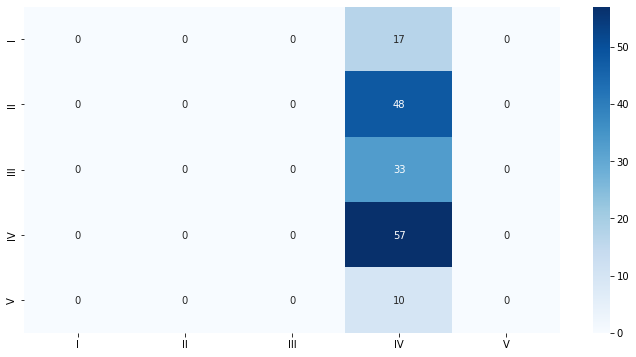

In [98]:
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label);

In [99]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        33
           3       0.35      1.00      0.51        57
           4       0.00      0.00      0.00        10

    accuracy                           0.35       165
   macro avg       0.07      0.20      0.10       165
weighted avg       0.12      0.35      0.18       165



Text(0.5, 1.0, 'Training and validation loss')

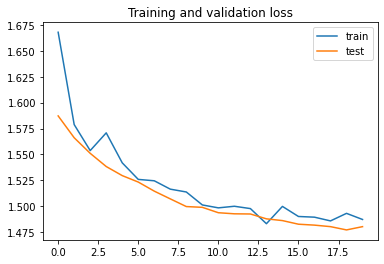

In [100]:
epochs = range(len(training_history.history['loss'])) # Get number of epochs

# plot loss learning curves
plt.plot(epochs, training_history.history['loss'], label = 'train')
plt.plot(epochs, training_history.history['val_loss'], label = 'test')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

Text(0.5, 1.0, 'Training and validation accuracy')

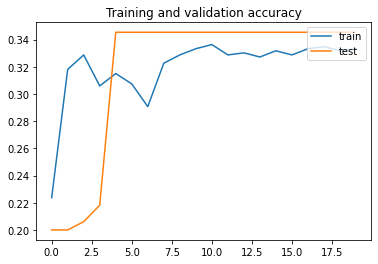

In [101]:
# plot accuracy learning curves
plt.plot(epochs, training_history.history['acc'], label = 'train')
plt.plot(epochs, training_history.history['val_acc'], label = 'test')
plt.legend(loc = 'upper right')
plt.title ('Training and validation accuracy')

In [ ]:
%cd /content/drive/MyDrive/AIML/Capstone

/content/drive/MyDrive/AIML/Capstone


In [ ]:
from keras.models import load_model
model = load_model('finalized_LSTM_model.h5')

In [ ]:
def model_prediction(usr_txt):
  with open('/content/drive/MyDrive/AIML/Capstone/parameters.pickle', "rb") as f:
      lab_en, tokenizer_data = pickle.load(f)
  from NLP_text_preprocess import PreProcessing
  pp = PreProcessing(to_lower = config.to_lower,remove_url=config.remove_url,
                   remove_time = config.remove_time,expand_contraction =config.expand_contraction,
                   remove_special_character=config.remove_special_character,
                   remove_punctuation=config.remove_punctuation,
                   remove_whitespace=config.remove_whitespace,
                   keep_alpha_numeric = False,
                   check_spelling=config.check_spelling,
                   remove_stopword=False,
                   lemmatize_word=config.lemmatize_word)

  pre_txt = pp.preprocess(usr_txt)
  tok_txt = tokenizer_data.texts_to_sequences([pre_txt])
  pad_txt = pad_sequences(tok_txt, padding='post', maxlen=185)
  prediction = model.predict(pad_txt, verbose=0)
  pred_index = np.argmax(prediction,axis=1)
  result = lab_en.inverse_transform(pred_index)[0]
  return print('The Potential accident level is', result)

In [ ]:
model_prediction(industry_df['Description_preprocessed'][1])

The Potential accident level is IV


## NLP Augmentation:

In [ ]:
try:
   import nlpaug.augmenter.word as naw
   import transformers
except ModuleNotFoundError:
  !pip install numpy requests nlpaug
  !pip install transformers
  import nlpaug.augmenter.word as naw
  import transformers

In [147]:
industry_df = pd.read_csv("industry_df_with_stopwords.csv")

In [48]:
aug_bert = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute",aug_max=10)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [49]:
augmented_text = aug_bert.augment(industry_df['Description_preprocessed'][1])
print("Original:")
print(industry_df['Description_preprocessed'][1])
print("Augmented Text:")
print(augmented_text)

Original:
during the activation of a sodium sulphide pump the piping wa uncoupled and the sulfide solution wa designed in the area to reach the maid immediately she made use of the emergency shower and wa directed to the ambulatory doctor and later to the hospital note of sulphide solution 48 gram liter
Augmented Text:
during the activation as a sodium sulphide pump the temperature wa uncoupled and the sulfide solution wa designed in any standard to reach the maid immediately when made light of the emergency shower and wa directed to the ambulatory doctor and later to the toilet head of water solution 100 gram liter


In [50]:
len(augmented_text)

302

In [51]:
len(industry_df['Description_preprocessed'][1])

294

In [42]:
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
def sent_token(text):
  sentences = sent_tokenize(text)
  return len(sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [45]:
industry_df['sentence_length'] = industry_df.Description.apply(lambda x: sent_token(x))

In [46]:
industry_df['sentence_length'].value_counts()

1    178
2    130
3     60
4     23
5     12
6      5
8      2
7      1
Name: sentence_length, dtype: int64

In [46]:
aug_roberta = naw.ContextualWordEmbsAug(
    model_path='roberta-base', action="substitute")

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

In [47]:
augmented_text = aug_roberta.augment(industry_df['Description_preprocessed'][1])
print("Original:")
print(industry_df['Description_preprocessed'][1])
print("Augmented Text:")
print(augmented_text)

Original:
during the activation of a sodium sulphide pump the piping wa uncoupled and the sulfide solution wa designed in the area to reach the maid immediately she made use of the emergency shower and wa directed to the ambulatory doctor and later to the hospital note of sulphide solution 48 gram liter
Augmented Text:
during my activation of a sodium backup pump we hose wa uncoupled and the sulfide solution wa designed in the area to reach the maid whilst she made use it the emergency shower and wa directed to my ambulatory doctor and added to the laundry note of her solution 48 gram liter


In [124]:
data_aug = pd.DataFrame()

In [125]:
data_aug['Description_preprocessed'] = industry_df.Description.apply(lambda x: aug_bert.augment(x))

In [126]:
data_aug['Potential_Accident_Level'] = industry_df['Potential_Accident_Level']

In [127]:
!pip uninstall pandas
!pip install pandas==1.1.5

Found existing installation: pandas 1.1.5
Uninstalling pandas-1.1.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pandas-1.1.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas/*
Proceed (y/n)? Y
  Successfully uninstalled pandas-1.1.5
  Using cached pandas-1.1.5-cp37-cp37m-manylinux1_x86_64.whl (9.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nlpaug 1.1.9 requires pandas>=1.2.0, but you have pandas 1.1.5 which is incompatible.


In [128]:
data_aug.to_csv('data_augmentation.csv', index=False)

In [148]:
data_aug = pd.read_csv("data_augmentation.csv")
data_aug.rename(columns={'Description_preprocessed':'Description'}, inplace=True)
data_aug.head()

,Description,Potential_Accident_Level
0,while removing the drill rod of the jumbo 08 f...,IV
1,during the activation of a second sulphide pum...,IV
2,in the sub - camp milpo located at 18 + 170 as...,III
3,being 9 : 17 am. approximately in the nv. 1880...,I
4,approximately at 11 : 45 a. m. in circumstance...,IV


In [149]:
industry_new = industry_df[['Description','Potential_Accident_Level']]

In [150]:
ind_aug = pd.concat([industry_new,data_aug], axis=0).reset_index(drop=True)
ind_aug

,Description,Potential_Accident_Level
0,While removing the drill rod of the Jumbo 08 f...,IV
1,During the activation of a sodium sulphide pum...,IV
2,In the sub-station MILPO located at level +170...,III
3,Being 9:45 am. approximately in the Nv. 1880 C...,I
4,Approximately at 11:45 a.m. in circumstances t...,IV
...,...,...
817,being approximately 5 : 00 p. m. approximately...,III
818,another company moved from our infrastructure ...,II
819,during the environmental monitoring activity i...,II
820,another employee performed the act of strippin...,II


In [151]:
ind_aug.iloc[1][0]

'During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter.'

In [152]:
ind_aug.iloc[412][0]

'during the activation of a second sulphide pump, the piping is uncoupled and the sulfide solution was collected in the area to reach the maid. immediately she commenced use within the emergency room and was directed to the ambulatory doctor and later to to hospital. use : of sulphide consumption = 48 gram / liter.'

In [65]:
ind_aug.shape

(822, 2)

In [134]:
ind_aug.to_csv('industry_augmentation.csv', index=False)